## 🚗 **Saudi Arabia Used-Car Price Optimization for Syarah.com**

---

### 🎯 **SCQA: Business Framing**

**Situation:**
Sellers on syarah.com, an online used-car marketplace in Saudi Arabia, regularly list vehicles for sale. Setting the right asking price is crucial for achieving timely sales and maintaining marketplace efficiency.

**Complication:**
Many sellers inaccurately price their vehicles due to limited market insights. Overpriced cars lead to slow sales and reduced marketplace liquidity, while underpriced cars result in lost profits for sellers and lower revenues for the platform.

**Question:**
How can syarah.com help sellers reliably set optimal asking prices to minimize pricing errors, accelerate sales, and improve both seller profitability and overall marketplace performance?

**Answer:**
Develop and deploy a robust machine-learning model that predicts accurate market-aligned prices for used cars, significantly reducing pricing errors. This will increase marketplace liquidity, accelerate sales, and maximize profit for both sellers and syarah.com.

---

### 📊 **Metrics & Evaluation**

**Primary Metric:**

* **Mean Absolute Error (MAE)** in Saudi Riyals (SAR)

  * Clear interpretation: "On average, our model is accurate within ±2,800 SAR."
  * Symmetric penalty for both overpriced and underpriced listings.
  * Robust against extreme high-price outliers.

**Companion Metric:**

* **Median Absolute Percentage Error (MdAPE)**

  * Provides fairness across different price ranges.
  * Offers clear interpretability: "Half our predictions fall within ±X% of actual prices."

**Business Impact Evaluation:**

* Based on model accuracy (\~5% MAE), assume predicted prices closely represent "true market value."
* Classify listings as:

  * **Overpriced:** Actual price > 5% above model prediction.
  * **Underpriced:** Actual price > 5% below model prediction.
  * **Well-priced:** Within ±5% range.
* Quantify business impact using:

  * **Underpriced cars:** Calculate potential profit recovered (price gap).
  * **Overpriced cars:** Estimate faster sale (e.g., assume 1 selling day saved per 2% price correction).

---

### 🤖 **Final Model & Benchmark Plan**

**Baseline Model:**

* **ElasticNet linear regression** (interpretable and simple)

  * Expected MAE ≈ 6,700 SAR.

**Final Selected Model:**

* ✅ **CatBoost Regressor**

  * Handles categorical variables natively (no need for extensive encoding).
  * Provides built-in interpretability (SHAP values).
  * Expected MAE ≈ 2,800 SAR (≈5% of average car price).

**Additional Comparison Models (Optional):**

* ✅ **XGBoost / LightGBM**

  * For validation, robustness, or slight performance gains.

---

### 🔍 **Data Preparation & Feature Engineering**

**Data Handling:**

* Remove listings marked as "Negotiable" (`Price = 0`)—mentor-confirmed safe.
* Light-touch outlier treatment (top 1% or ±3σ only) to match hidden test conditions.

**Feature Engineering (Minimal, business-relevant):**

* `CarAge = 2025 - Year`
* Raw categorical features (`Make`, `Type`, `Region`, `Gear_Type`, `Options`) for CatBoost.

---

### 📉 **Model Interpretability**

* Utilize **SHAP plots** (from CatBoost) to visually communicate feature importance to stakeholders.
* Identify clear business insights (key pricing factors like Age, Mileage, Brand).

---

### 📈 **Deployment Scenario (Hypothetical)**

* Model integrated directly into syarah.com’s user interface.
* Sellers receive immediate, accurate price recommendations upon listing cars.
* Marketplace moderators leverage predictions to identify and flag mispriced listings.

---

### 🧪 **Final Evaluation Plan**

* Perform cross-validation (80/20 split, random or grouped by `Make`).
* Evaluate and report metrics:

  * MAE (primary) and MdAPE (companion).
* Calculate and clearly present business impact (money saved, sales accelerated).

---

### 🚩 **Final Project Summary Table**

| Aspect               | Final Decision                                                          |
| -------------------- | ----------------------------------------------------------------------- |
| **Stakeholder/User** | Hypothetical used-car marketplace (syarah.com)                          |
| **Primary Metric**   | Mean Absolute Error (MAE) in SAR (\~2,800 target, \~5% of avg price)    |
| **Companion Metric** | Median Absolute Percentage Error (MdAPE)                                |
| **Benchmark Model**  | ElasticNet linear regression (\~6,700 SAR MAE)                          |
| **Final Model**      | CatBoost Regressor (\~2,800 SAR MAE)                                    |
| **Optional Models**  | XGBoost, LightGBM                                                       |
| **Data Handling**    | Drop Negotiable prices, minimal outlier removal (top 1% or ±3σ)         |
| **Business Impact**  | ±5% threshold for mispricing: calculate profit recovered & faster sales |
| **Interpretability** | SHAP values (built-in CatBoost)                                         |

---

### ✨ **Concise One-Liner Project Narrative**

> "**I built a CatBoost model to help syarah.com accurately price used cars, significantly reducing typical seller mispricing errors, saving thousands of Riyals per car, accelerating marketplace sales, and enhancing overall platform performance.**"

1. Normally, when the dataset has no missing data, do we still put in imputers in the model just in case the new real-world data has some missing data?
2. What if the test set has a negotiable price in it? That would ruin my model performance especially if I decide to drop the negotiable rows as I do not have control over the test dataset
3. Is choosing boosting methods like CatBoost or XGBoost and further Ensemble Methods fine? Or is it too much for a task like this and better to go for simpler models like multiple linear regression?

# Import Libraries & Dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH = '../data/data_saudi_used_cars.csv'

In [3]:
df = pd.read_csv(DATASET_PATH)
df.head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0


# Data Understanding

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5624 entries, 0 to 5623
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         5624 non-null   object 
 1   Region       5624 non-null   object 
 2   Make         5624 non-null   object 
 3   Gear_Type    5624 non-null   object 
 4   Origin       5624 non-null   object 
 5   Options      5624 non-null   object 
 6   Year         5624 non-null   int64  
 7   Engine_Size  5624 non-null   float64
 8   Mileage      5624 non-null   int64  
 9   Negotiable   5624 non-null   bool   
 10  Price        5624 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 445.0+ KB


In [5]:
df.isna().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

From the result above, we have 5624 rows of data with no missing values. We have 6 categorical columns, 1 boolean column, and 4 numerical columns. All data types looks correct except `Price` (need a deeper look and consider converting it into a float).

In [6]:
df.duplicated().sum()

4

In [7]:
df[df.duplicated(keep=False)]

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
236,Sonata,Jeddah,Hyundai,Automatic,Saudi,Standard,2020,2.4,100,False,72910
540,Rio,Riyadh,Kia,Automatic,Saudi,Standard,2016,1.4,270000,False,25000
953,Rio,Riyadh,Kia,Automatic,Saudi,Standard,2016,1.4,270000,False,25000
2012,Tucson,Dammam,Hyundai,Automatic,Saudi,Standard,2016,2.0,155000,False,45000
3631,Camry,Riyadh,Toyota,Automatic,Saudi,Full,2013,2.5,185000,True,0
4646,Sonata,Jeddah,Hyundai,Automatic,Saudi,Standard,2020,2.4,100,False,72910
4933,Tucson,Dammam,Hyundai,Automatic,Saudi,Standard,2016,2.0,155000,False,45000
5267,Camry,Riyadh,Toyota,Automatic,Saudi,Full,2013,2.5,185000,True,0


There are 4 exact duplicates found in the dataset. After inspection, it is safe to remove these duplicates since these duplicates do not contain any meaningful data/context for our predictive model.

In [8]:
df = df.drop_duplicates()
df.shape[0]

5620

### Excluding Negotiable Prices

In this dataset, car listings with `"Negotiable" = True` have a `Price` value of **0**, which does not reflect the actual market price. Including these rows would:

- **Distort distribution** of price-related statistics (mean, median, outliers)
- **Skew visualizations** like boxplots or scatter plots
- **Confuse model training**, since a price of 0 is not a valid learning signal

### Solution:
I exclude `Negotiable == True` rows from:
- Exploratory Data Analysis (EDA)
- Model training and evaluation

This ensures that I train and evaluate our model only on cars with fixed, known prices, leading to more accurate and reliable insights.

In [9]:
# Calculate the number of rows with Negotiable as True
negotiable_true_count = df['Negotiable'].sum()

# Calculate the percentage
negotiable_true_percentage = (negotiable_true_count / len(df)) * 100

print(f"Number of cars with Negotiable=True: {negotiable_true_count}")
print(f"Percentage of cars with Negotiable=True: {negotiable_true_percentage:.2f}%")

# Check how many of these have Price = 0
negotiable_zero_price = df[(df['Negotiable'] == True) & (df['Price'] == 0)]
print(f"\nNumber of negotiable cars with Price=0: {len(negotiable_zero_price)}")
print(f"Percentage of negotiable cars with Price=0: {(len(negotiable_zero_price) / negotiable_true_count) * 100:.2f}%")

Number of cars with Negotiable=True: 1795
Percentage of cars with Negotiable=True: 31.94%

Number of negotiable cars with Price=0: 1795
Percentage of negotiable cars with Price=0: 100.00%


In [10]:
df_filtered = df[df['Negotiable'] == False]

### Finding Invalid Price Value (Price == 0)

In [11]:
df_filtered[df_filtered['Price'] == 0]

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
3168,Furniture,Riyadh,Toyota,Automatic,Other,Semi Full,2012,2.7,225000,False,0


After filtering the Negotiable prices, it is found that there is 1 listing with a price of 0 even though it is non-negotiable. This value is considered as invalid as it is not realistic for a person to sell a car for free. Therefore, I will exclude this from the dataset as well.

In [12]:
df_filtered = df_filtered[df_filtered['Price'] > 0]

Data before initial cleaning:

In [39]:
df.describe(include='all')

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
count,5620,5620,5620,5620,5620,5620,5620.000000,5620.000000,5.620000e+03,5620,5620.000000
unique,347,27,58,2,4,3,NaN,NaN,NaN,2,NaN
top,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full,NaN,NaN,NaN,False,NaN
freq,269,2270,1430,4871,4184,2232,NaN,NaN,NaN,3825,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2014.100356,3.296299,1.509222e+05,NaN,53086.404448
std,NaN,NaN,NaN,NaN,NaN,NaN,5.793003,1.515253,3.829633e+05,NaN,70175.153207
min,NaN,NaN,NaN,NaN,NaN,NaN,1963.000000,1.000000,1.000000e+02,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,2.000000,3.800000e+04,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,3.000000,1.030000e+05,NaN,36500.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,4.500000,1.960000e+05,NaN,73000.000000


Data after initial cleaning:

In [13]:
df_filtered.describe(include='all')

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
count,3824,3824,3824,3824,3824,3824,3824.000000,3824.000000,3.824000e+03,3824,3824.000000
unique,320,27,56,2,4,3,NaN,NaN,NaN,1,NaN
top,Camry,Riyadh,Toyota,Automatic,Saudi,Full,NaN,NaN,NaN,False,NaN
freq,149,1615,889,3420,2893,1473,NaN,NaN,NaN,3824,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2014.851203,3.181119,1.426211e+05,NaN,78019.245031
std,NaN,NaN,NaN,NaN,NaN,NaN,5.110916,1.458832,3.783942e+05,NaN,72748.182183
min,NaN,NaN,NaN,NaN,NaN,NaN,1963.000000,1.000000,1.000000e+02,NaN,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2013.000000,2.000000,4.800000e+04,NaN,35000.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,2.700000,1.030000e+05,NaN,58000.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,4.000000,1.830000e+05,NaN,94250.000000


After the price filtering, 27 `Type` and 2 `Make` are also indirectly filtered out, meaning those Types and Makes are all negotiable in this dataset and are likely to only have few rows in the original dataset.

In [40]:
# Find Types and Makes present in df but missing in df_filtered
types_removed = set(df['Type'].unique()) - set(df_filtered['Type'].unique())
makes_removed = set(df['Make'].unique()) - set(df_filtered['Make'].unique())

# Pick one Type and one Make that were filtered out
type_example = next(iter(types_removed))
make_example = next(iter(makes_removed))

# Show all rows from df for the selected Type and Make
print(f"Example of filtered-out Type: {type_example}")
display(df[df['Type'] == type_example])

print(f"\nExample of filtered-out Make: {make_example}")
display(df[df['Make'] == make_example])

Example of filtered-out Type: Crown


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
3863,Crown,Dammam,Toyota,Manual,Saudi,Standard,1990,2.8,187000,True,0



Example of filtered-out Make: SsangYong


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
3828,Koranado,Riyadh,SsangYong,Automatic,Gulf Arabic,Semi Full,2013,2.0,157,True,0


For example, both Crown `Type` and SsangYong `Make` only have 1 listing in the dataset, and both listings are negotiable.

## 📊 Initial Data Exploration Summary

### 🧾 Dataset Overview

* **Total rows**: 3,824
* **Columns**: 11 (6 categorical, 1 boolean, 4 numerical)
* **No missing values & removed 4 duplicates**

---

### 🔍 Categorical Features

* **High cardinality**

  * `Type`: 320 unique models
  * `Make`: 56 brands
* **Moderate cardinality**

  * `Region`: 27 areas
* **Dominant categories**

  * **Make**: Toyota (\~23%)
  * **Type**: Camry (\~4%)
  * **Region**: Riyadh (\~42%)
  * **Gear\_Type**: Automatic (\~89%)
  * **Origin**: Saudi (\~76%)
  * **Options**: Full (\~39%)

> ⚠️ Heavy skew: a handful of categories cover most listings; long tail of rare values remains.

---

### 🔢 Numerical Features

| Feature              | Min  | 25 %   | 50 %    | Mean    | 75 %    | Max        |
| -------------------- | ---- | ------ | ------- | ------- | ------- | ---------- |
| **Year**             | 1963 | 2013   | 2016    | 2015    | 2018    | 2021       |
| **Engine\_Size (L)** | 1.0  | 2.0    | 2.7     | 3.18    | 4.0     | 9.0        |
| **Mileage (km)**     | 100  | 48,000 | 103,000 | 142,600 | 183,000 | 20,000,000 |
| **Price (SAR)**      | 1    | 35,000 | 58,000  | 78,019  | 94,250  | 850,000    |

> ⚠️ Mileage and Price have extreme outliers

---

### ✅ Key Takeaways

1. **Filtered out** 1,795 negotiable listings and 1 invalid 0-price listing -> using 3,824 fixed-price entries.
2. **High cardinality** in `Type` & `Make`, with strong region skew -> encoding/aggregation needed.
3. **Long tails & outliers** (Mileage, Price) require attention before modeling.
4. Clean and ready for detailed EDA & preprocessing.

# Detailed Features Data Exploration

In this section, we'll explore each feature in more detail to understand more about the data that we have

In [14]:
df_filtered.columns

Index(['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options', 'Year',
       'Engine_Size', 'Mileage', 'Negotiable', 'Price'],
      dtype='object')

## Type

In [15]:
# 1. Quick summary statistics
print("Unique Type count:", df_filtered['Type'].nunique())

# 2. Find possible typos/near-duplicates (trailing spaces, different case)
types_raw = pd.Series(df_filtered['Type'].unique())
suspect_types = types_raw[types_raw.str.strip().str.lower().duplicated(keep=False)]
print("\nPossible near-duplicate or inconsistent Type names:")
print(suspect_types)

Unique Type count: 320

Possible near-duplicate or inconsistent Type names:
Series([], dtype: object)


In [16]:
df_filtered['Type'].value_counts()

Type
Camry           149
Land Cruiser    148
Accent          147
Hilux           118
Sonata          115
               ... 
Suvana            1
EC8               1
HS                1
A4                1
S8                1
Name: count, Length: 320, dtype: int64

In [17]:
print("\nTop 20 most common Types:")
print(df_filtered['Type'].value_counts().head(20))

# Calculate the percentage of data represented by top 20 car types
top_types = df_filtered['Type'].value_counts().head(20)
top_20_percentage = top_types.sum() / len(df_filtered) * 100

# Print the percentage
print(f"\nTop 20 Types represent {top_20_percentage:.2f}% of all cars")

# Find the minimum and maximum counts in the top 20
max_value = top_types.max()
max_index = top_types.idxmax()
min_value = top_types.tail(1).values[0]
min_index = 19  # Index of the 20th item

print(f"Most common: {max_index} ({max_value} cars)")
print(f"20th most common: {top_types.index[-1]} ({min_value} cars)")


Top 20 most common Types:
Type
Camry           149
Land Cruiser    148
Accent          147
Hilux           118
Sonata          115
Elantra         105
Taurus          102
Tahoe           100
Yukon            93
Corolla          82
Expedition       76
Furniture        62
Sunny            60
Range Rover      60
S                59
Yaris            57
Accord           55
Prado            55
Pajero           55
ES               51
Name: count, dtype: int64

Top 20 Types represent 45.74% of all cars
Most common: Camry (149 cars)
20th most common: ES (51 cars)


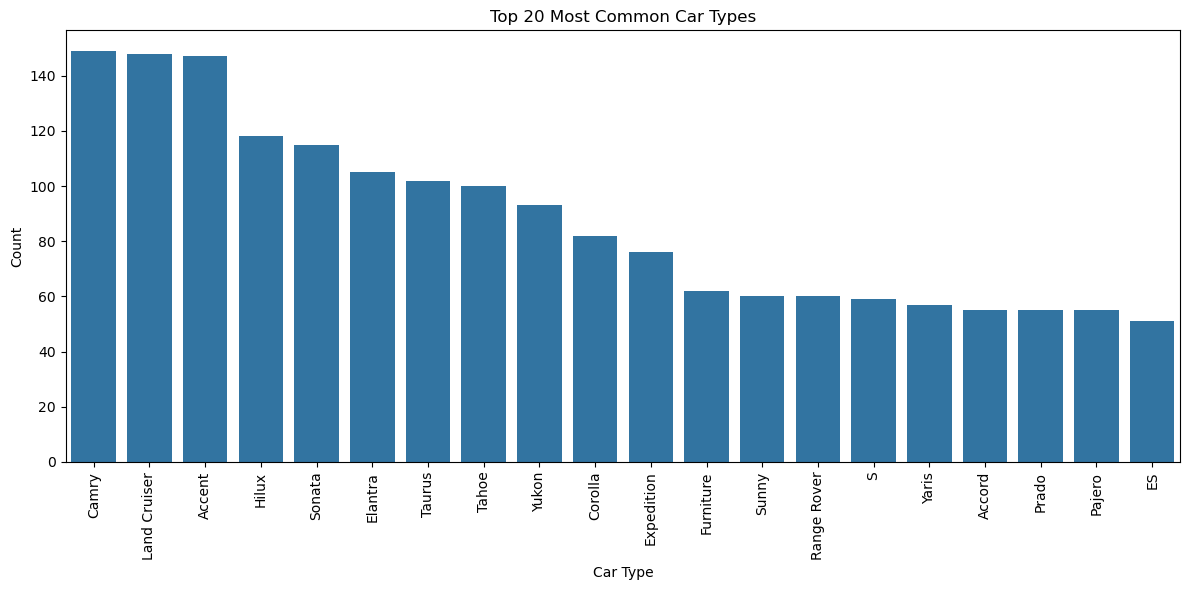

In [18]:
# 3. Visualization: Bar chart of top 20 Types
plt.figure(figsize=(12, 6))
sns.barplot(x=top_types.index, y=top_types.values)
plt.title('Top 20 Most Common Car Types')
plt.ylabel('Count')
plt.xlabel('Car Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Top 72 types account for 80% of the data.
The 80th percentile car type is: Other
These top 72 models represent 22.50% of all unique car types/models, and they represent 80.13% of all cars in the dataset.


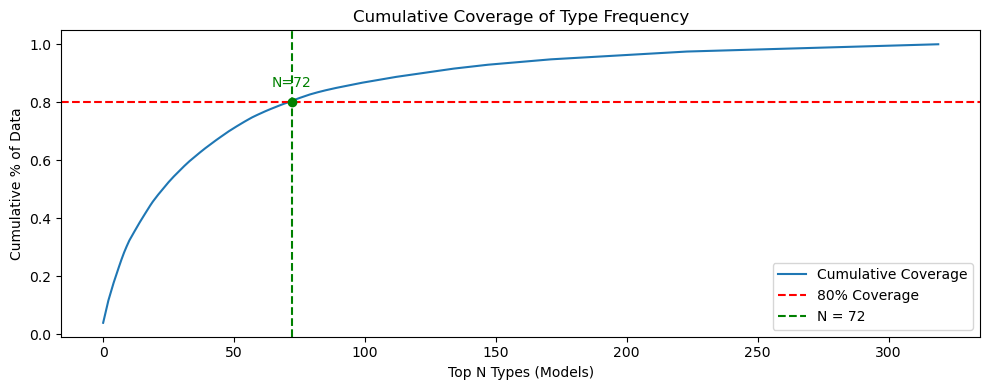

In [19]:
# Frequency table
type_counts = df_filtered['Type'].value_counts()

# 4. Cumulative sum
cumsum = type_counts.cumsum() / type_counts.sum()

# Find N where cumulative sum >= 80%
pareto_80 = (cumsum >= 0.8).idxmax()  # Gives the actual Type (model) name
N_80 = (cumsum >= 0.8).argmax() + 1   # +1 because index is zero-based

# Calculate the percentage that top N_80 models represent
top_n80_percentage = cumsum.values[N_80-1] * 100
percentage_of_unique_types = (N_80 / len(type_counts)) * 100

print(f"Top {N_80} types account for 80% of the data.")
print(f"The 80th percentile car type is: {pareto_80}")
print(f"These top {N_80} models represent {percentage_of_unique_types:.2f}% of all unique car types/models, and they represent {top_n80_percentage:.2f}% of all cars in the dataset.")

# Plot with annotation
plt.figure(figsize=(10, 4))
plt.plot(cumsum.values, label='Cumulative Coverage')
plt.axhline(0.8, color='r', linestyle='--', label='80% Coverage')
plt.axvline(N_80, color='g', linestyle='--', label=f'N = {N_80}')
plt.scatter(N_80, cumsum.values[N_80-1], color='g', zorder=5)
plt.text(N_80, cumsum.values[N_80-1]+0.05, f'N={N_80}', color='g', ha='center')
plt.title('Cumulative Coverage of Type Frequency')
plt.xlabel('Top N Types (Models)')
plt.ylabel('Cumulative % of Data')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# 5. Find "rare" Types (less than 10 rows)
rare_types = type_counts[type_counts < 10]
rare_percentage = (len(rare_types) / len(type_counts)) * 100
print(f"\nNumber of rare Types (<10 rows): {len(rare_types)} out of {len(type_counts)} total Types ({rare_percentage:.2f}%)")
print("Example rare Types:", rare_types.head())


Number of rare Types (<10 rows): 238 out of 320 total Types (74.38%)
Example rare Types: Type
CX5        9
Acadia     9
Sorento    9
D-MAX      8
Duster     8
Name: count, dtype: int64


74% of car types in the dataset have less than 10 rows, which might be a limitation for the predictive model for these rare cars in the real-world dataset.

In [44]:
df_filtered[df_filtered['Type'] == 'Other']

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
663,Other,Qassim,Other,Manual,Other,Standard,1980,2.4,2500,False,220000
881,Other,Al-Baha,Other,Manual,Other,Standard,2020,1.1,2848,False,2000
1186,Other,Dammam,Hyundai,Automatic,Other,Full,2011,4.6,270,False,30000
1199,Other,Qassim,Other,Manual,Other,Full,2019,8.0,24643,False,330000
1253,Other,Al-Medina,Other,Manual,Other,Standard,2009,2.4,1300,False,26000
1629,Other,Jeddah,Other,Manual,Other,Semi Full,2021,1.2,3000,False,5500
1717,Other,Jeddah,Honda,Manual,Saudi,Standard,2011,1.0,4200,False,6500
1979,Other,Al-Medina,Mitsubishi,Manual,Saudi,Standard,2006,2.5,140000,False,45000
3542,Other,Riyadh,Geely,Automatic,Saudi,Full,2017,1.4,45000,False,36000
3608,Other,Khobar,Porsche,Automatic,Saudi,Full,2020,5.0,18000,False,375000


There is also an 'Other' value in Type, containing 13 rows of cars

### 🔍 Feature Analysis: `Type` (Car Model)

- **Unique Types**: 320 (after removing negotiable and invalid price listings)
- **Most Common Type**: Camry (149 listings, ~3.9%)
- **Top 20 Types**: Account for **45.74%** of all listings
- **Skewed Distribution**:  
  - **Top 72 models (22.5%)** already represent **80%** of the data
  - **238 out of 320 types (74%)** have **fewer than 10 rows**

> This shows a classic **long-tail distribution** where most models appear very rarely.

- **No typos or inconsistent casing/spacing** were detected
- There is a pre-existing `"Other"` value in the data with 13 rows.

### ⚠️ Implications

- Model will learn best on common car types (e.g. Camry, Land Cruiser, Accent), but may underperform on rare types.
- For traditional models like linear regression or one-hot encoded baselines, might consider grouping rare types into a new label (e.g. `'Rare_Model'`) to reduce noise and feature sparsity.
- If using **CatBoost**, I can safely leave raw values (even rare ones), as it handles rare categories natively.

## Region

### **Checklist for `Region` Column**

* **Sanity checks**:

  * Are there typos, inconsistent naming, or trailing spaces?
  * Are all regions real (exist in Saudi Arabia)?
  * Any “unknown”, “other”, or blank values?
  * Are there regions with very few listings?

* **Distribution analysis**:

  * Which regions dominate the data?
  * How many regions cover most listings (Pareto principle)?
  * How many rare regions (<10 cars)?

* **Visualization**:

  * Bar chart of top regions
  * Cumulative coverage plot (Pareto)
  * (Optional) Map visualization if you have lat/lon info

In [22]:
# 1. Quick summary
print("Unique Region count:", df_filtered['Region'].nunique())
print("\nTop 10 most common Regions:")
print(df_filtered['Region'].value_counts().head(10))

Unique Region count: 27

Top 10 most common Regions:
Region
Riyadh       1615
Dammam        748
Jeddah        546
Al-Medina     124
Qassim        112
Al-Ahsa       111
Makkah         87
Aseer          87
Taef           53
Khobar         51
Name: count, dtype: int64


In [23]:
# 2. Data quality: check for possible typos/inconsistencies
regions_raw = pd.Series(df_filtered['Region'].unique())
suspect_regions = regions_raw[regions_raw.str.strip().str.lower().duplicated(keep=False)]
print("\nPossible near-duplicate or inconsistent Region names:")
print(suspect_regions)


Possible near-duplicate or inconsistent Region names:
Series([], dtype: object)


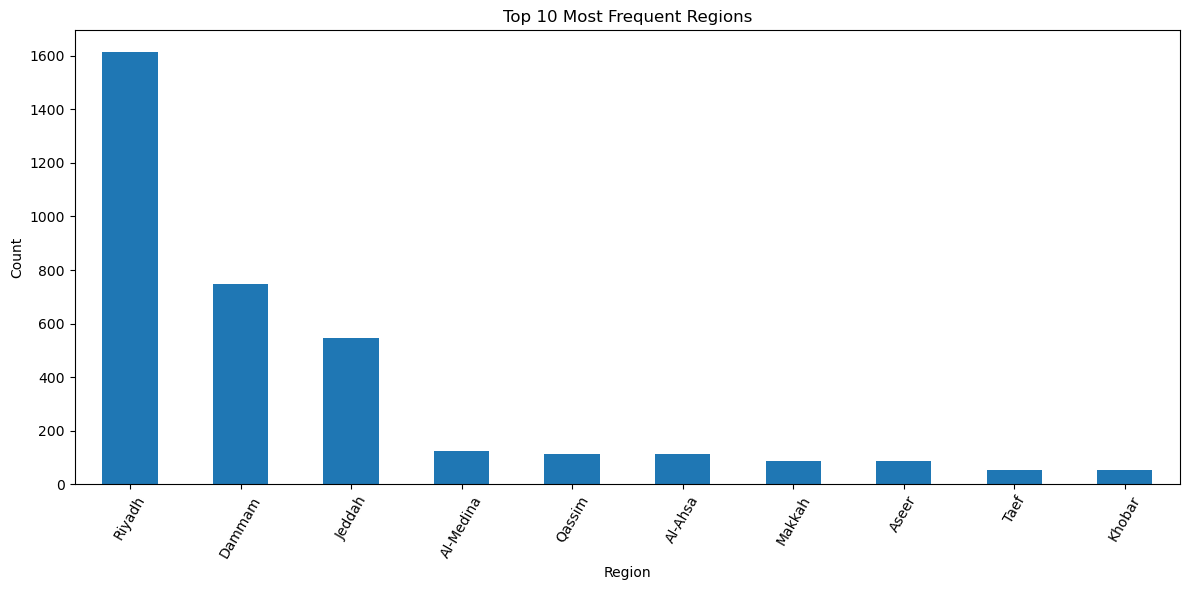

In [24]:
# 3. Frequency table
region_counts = df_filtered['Region'].value_counts()

# 4. Plot: Top 15 Regions
plt.figure(figsize=(12, 6))
region_counts.head(10).plot(kind='bar')
plt.title('Top 10 Most Frequent Regions')
plt.ylabel('Count')
plt.xlabel('Region')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

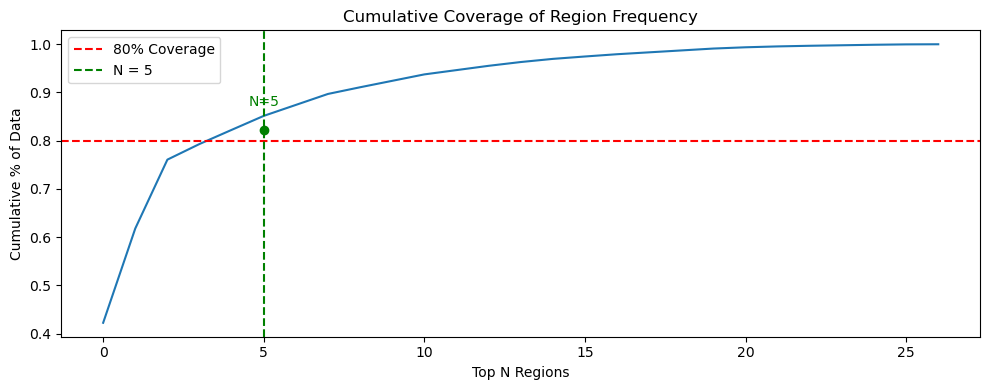

Top 5 regions account for 80% of the data.
The 80th percentile region is: Qassim
These top 5 regions represent 18.52% of all unique regions, and they represent 82.24% of all cars in the dataset.


In [25]:
# 5. Cumulative coverage (Pareto)
region_cumsum = region_counts.cumsum() / region_counts.sum()
pareto_80 = (region_cumsum >= 0.8).idxmax()
N_80 = (region_cumsum >= 0.8).argmax() + 1

plt.figure(figsize=(10, 4))
plt.plot(region_cumsum.values)
plt.axhline(0.8, color='r', linestyle='--', label='80% Coverage')
plt.axvline(N_80, color='g', linestyle='--', label=f'N = {N_80}')
plt.scatter(N_80, region_cumsum.values[N_80-1], color='g', zorder=5)
plt.text(N_80, region_cumsum.values[N_80-1]+0.05, f'N={N_80}', color='g', ha='center')
plt.title('Cumulative Coverage of Region Frequency')
plt.xlabel('Top N Regions')
plt.ylabel('Cumulative % of Data')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Top {N_80} regions account for 80% of the data.")
print(f"The 80th percentile region is: {pareto_80}")
percentage_of_unique_regions = (N_80 / len(region_counts)) * 100
top_n80_percentage = region_cumsum.values[N_80-1] * 100
print(f"These top {N_80} regions represent {percentage_of_unique_regions:.2f}% of all unique regions, and they represent {top_n80_percentage:.2f}% of all cars in the dataset.")

In [26]:
# 6. Find rare Regions (<10 listings)
rare_regions = region_counts[region_counts < 10]
rare_percentage = (len(rare_regions) / len(region_counts)) * 100
print(f"\nNumber of rare Regions (<10 rows): {len(rare_regions)} out of {len(region_counts)} total Regions ({rare_percentage:.2f}%)")
print("Example rare Regions:", rare_regions.head())


Number of rare Regions (<10 rows): 6 out of 27 total Regions (22.22%)
Example rare Regions: Region
Arar            7
Wadi Dawasir    5
Qurayyat        4
Sakaka          4
Besha           3
Name: count, dtype: int64


In [27]:
df_filtered['Region'].value_counts()

Region
Riyadh            1615
Dammam             748
Jeddah             546
Al-Medina          124
Qassim             112
Al-Ahsa            111
Makkah              87
Aseer               87
Taef                53
Khobar              51
Tabouk              51
Jazan               34
Jubail              34
Abha                30
Hail                25
Najran              19
Al-Baha             18
Yanbu               15
Al-Jouf             15
Hafar Al-Batin      15
Al-Namas            10
Arar                 7
Wadi Dawasir         5
Qurayyat             4
Sakaka               4
Besha                3
Sabya                1
Name: count, dtype: int64

### 🔍 Feature Analysis: `Region`

- **Unique Regions**: 27  
- **Top 5 Regions** (80% Pareto point):  
  1. Riyadh (1,615 listings, 42.3%)  
  2. Dammam (748, 19.6%)  
  3. Jeddah (546, 14.3%)  
  4. Al-Medina (124, 3.2%)  
  5. Qassim   (112, 2.9%)  
- **Coverage**: Top 5 regions (18.5% of all regions) account for **82.2%** of listings  
- **Rare Regions**: 6 regions (~22% of regions) have **<10 listings**  
  - Examples: Arar (7), Wadi Dawasir (5), Qurayyat (4), Sakaka (4), Besha (3), Sabya (1)  
- **Data Quality**: No typos or inconsistent naming detected  

### ⚠️ Implications

- The model will learn best for the major hubs (Riyadh, Dammam, Jeddah).  
- Rare regions may need to be grouped into an “Other_Region” bucket or handled with robust encoders to avoid noisy estimates.  
- Geographic skew reflects actual market concentration—focus business insights on high-volume areas but be cautious interpreting low-volume regions.

## Make

### 📝 **EDA & Data Quality Checklist for `Make`**

* **Sanity checks:**

  * Are there typos, inconsistent naming, or extra spaces?
  * Are there rare makes (with very few listings)?

* **Distribution analysis:**

  * Which makes dominate the data?
  * How many makes cover 80% of listings (Pareto)?
  * How many rare makes (<10 cars)?

* **Visualization:**

  * Bar chart of top makes
  * Cumulative coverage plot (Pareto)

In [28]:
# 1. Quick summary
print("Unique Make count:", df_filtered['Make'].nunique())
print("\nTop 10 most common Makes:")
print(df_filtered['Make'].value_counts().head(10))

Unique Make count: 56

Top 10 most common Makes:
Make
Toyota       889
Hyundai      512
Ford         346
Chevrolet    296
Nissan       252
Kia          186
Mercedes     173
GMC          167
Lexus        146
Mazda         92
Name: count, dtype: int64


In [29]:
# 2. Data quality: check for possible typos/inconsistencies
makes_raw = pd.Series(df_filtered['Make'].unique())
suspect_makes = makes_raw[makes_raw.str.strip().str.lower().duplicated(keep=False)]
print("\nPossible near-duplicate or inconsistent Make names:")
print(suspect_makes)


Possible near-duplicate or inconsistent Make names:
Series([], dtype: object)


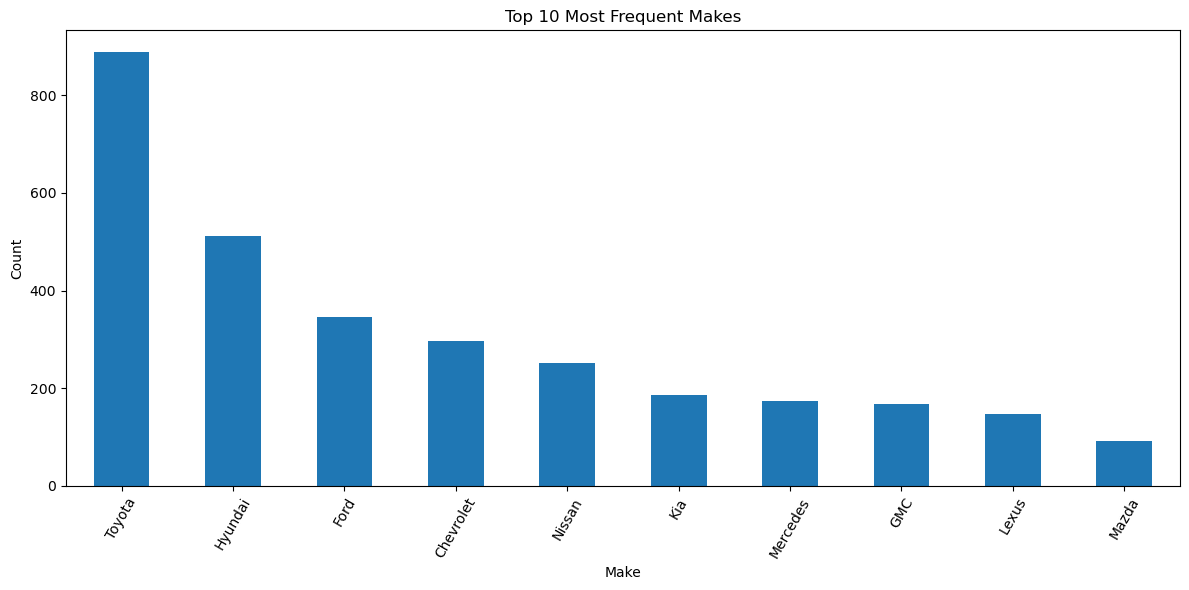

In [30]:
# 3. Frequency table
make_counts = df_filtered['Make'].value_counts()

# 4. Plot: Top 10 Makes
plt.figure(figsize=(12, 6))
make_counts.head(10).plot(kind='bar')
plt.title('Top 10 Most Frequent Makes')
plt.ylabel('Count')
plt.xlabel('Make')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

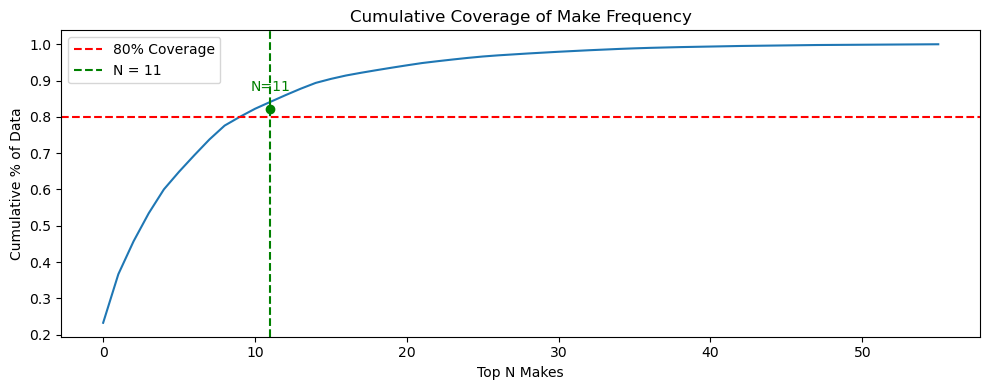

Top 11 makes account for 80% of the data.
The 80th percentile make is: Honda
These top 11 makes represent 19.64% of all unique makes, and they represent 82.22% of all cars in the dataset.


In [31]:
# 5. Cumulative coverage (Pareto)
make_cumsum = make_counts.cumsum() / make_counts.sum()
pareto_80_make = (make_cumsum >= 0.8).idxmax()
N_80_make = (make_cumsum >= 0.8).argmax() + 1

plt.figure(figsize=(10, 4))
plt.plot(make_cumsum.values)
plt.axhline(0.8, color='r', linestyle='--', label='80% Coverage')
plt.axvline(N_80_make, color='g', linestyle='--', label=f'N = {N_80_make}')
plt.scatter(N_80_make, make_cumsum.values[N_80_make-1], color='g', zorder=5)
plt.text(N_80_make, make_cumsum.values[N_80_make-1]+0.05, f'N={N_80_make}', color='g', ha='center')
plt.title('Cumulative Coverage of Make Frequency')
plt.xlabel('Top N Makes')
plt.ylabel('Cumulative % of Data')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Top {N_80_make} makes account for 80% of the data.")
print(f"The 80th percentile make is: {pareto_80_make}")
percentage_of_unique_makes = (N_80_make / len(make_counts)) * 100
top_n80_make_percentage = make_cumsum.values[N_80_make-1] * 100
print(f"These top {N_80_make} makes represent {percentage_of_unique_makes:.2f}% of all unique makes, and they represent {top_n80_make_percentage:.2f}% of all cars in the dataset.")


In [32]:
# 6. Find rare Makes (<10 listings)
rare_makes = make_counts[make_counts < 10]
rare_percentage_make = (len(rare_makes) / len(make_counts)) * 100
print(f"\nNumber of rare Makes (<10 rows): {len(rare_makes)} out of {len(make_counts)} total Makes ({rare_percentage_make:.2f}%)")
print("Example rare Makes:", rare_makes.head())


Number of rare Makes (<10 rows): 27 out of 56 total Makes (48.21%)
Example rare Makes: Make
Lincoln    9
HAVAL      9
Jaguar     8
MINI       8
Peugeot    7
Name: count, dtype: int64


In [33]:
# Exclude the Top 10 most common Makes from the value counts
df_filtered['Make'].value_counts().iloc[10:]

Make
Honda           85
BMW             72
Mitsubishi      71
Dodge           68
Land Rover      62
Jeep            42
Chrysler        36
Genesis         29
Audi            27
Renault         26
Cadillac        25
Changan         24
Geely           19
MG              18
Volkswagen      17
Porsche         15
Isuzu           12
INFINITI        10
Suzuki          10
Lincoln          9
HAVAL            9
Jaguar           8
MINI             8
Peugeot          7
Mercury          7
Fiat             6
Other            5
Daihatsu         4
Bentley          4
FAW              3
Rolls-Royce      3
Maserati         3
GAC              3
Great Wall       2
Hummer           2
Aston Martin     2
Zhengzhou        2
Foton            2
BYD              1
Škoda            1
Iveco            1
Lifan            1
Chery            1
Classic          1
Victory Auto     1
Ferrari          1
Name: count, dtype: int64

In [45]:
df_filtered[df_filtered['Make'] == 'Other']

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
663,Other,Qassim,Other,Manual,Other,Standard,1980,2.4,2500,False,220000
881,Other,Al-Baha,Other,Manual,Other,Standard,2020,1.1,2848,False,2000
1199,Other,Qassim,Other,Manual,Other,Full,2019,8.0,24643,False,330000
1253,Other,Al-Medina,Other,Manual,Other,Standard,2009,2.4,1300,False,26000
1629,Other,Jeddah,Other,Manual,Other,Semi Full,2021,1.2,3000,False,5500


There is also an 'Other' value on `Make`, with 5 listings.

### 🔍 Feature Analysis: `Make`

- **Unique Makes**: 56  
- **Top 5 Makes**:  
  1. Toyota (889 listings, 23.3%)  
  2. Hyundai (512, 13.4%)  
  3. Ford    (346, 9.1%)  
  4. Chevrolet (296, 7.8%)  
  5. Nissan   (252, 6.6%)  
- **Pareto Insight**:  
  - Top 11 makes (19.6% of all makes) cover **82.2%** of listings  
- **Long Tail**:  
  - 27 out of 56 makes (48.2%) have **<10 listings** (e.g. Lincoln, HAVAL, Jaguar)  
- **Raw “Other” Label**:  
  - There are 5 listings with `Make = "Other"` in the source data.

### ⚠️ Implications

- The model will be strongest for common brands like Toyota and Hyundai, but may struggle or overfit on under-represented makes.  
- For one-hot or linear baselines, might need to group all makes with fewer than 10 observations into a `Rare_Make` category to improve stability and reduce dimensionality.
- With CatBoost (or similar), I can leave raw strings as these libraries handle rare categories natively.  

## Gear Type

### EDA Steps for `Gear_Type`

1. **Check for unique values and distribution**
2. **Check for typos or inconsistent labels**
3. **Visualize distribution**

### What to Look For

* Are there only “Automatic” and “Manual”, or are there unexpected/rare/invalid labels?
* Does the distribution align with expectations for the Saudi used car market (Automatic is expected to dominate)?
* Any “Other”, “Unknown”, or strange values?

In [51]:
# 1. Unique values and count
print("Unique Gear_Type values:", df_filtered['Gear_Type'].unique())
gear_counts = df_filtered['Gear_Type'].value_counts()
print(gear_counts)

# Percentage comparison
total = gear_counts.sum()
percentages = (gear_counts / total * 100).round(2)
print("\nPercentage breakdown:")
for gear_type, pct in percentages.items():
    print(f"{gear_type}: {pct}%")

Unique Gear_Type values: ['Automatic' 'Manual']
Gear_Type
Automatic    3420
Manual        404
Name: count, dtype: int64

Percentage breakdown:
Automatic: 89.44%
Manual: 10.56%


For `Gear Type`, there are only 2 values: Automatic & Manual.

Most cars being listed on the website here is Automatic cars, with them representing almost 90% of listings.

In [48]:
# 2. Check for possible typos/inconsistencies
gear_raw = pd.Series(df_filtered['Gear_Type'].unique())
suspect_gear = gear_raw[gear_raw.str.strip().str.lower().duplicated(keep=False)]
print("Possible near-duplicate or inconsistent Gear_Type labels:")
print(suspect_gear)

Possible near-duplicate or inconsistent Gear_Type labels:
Series([], dtype: object)


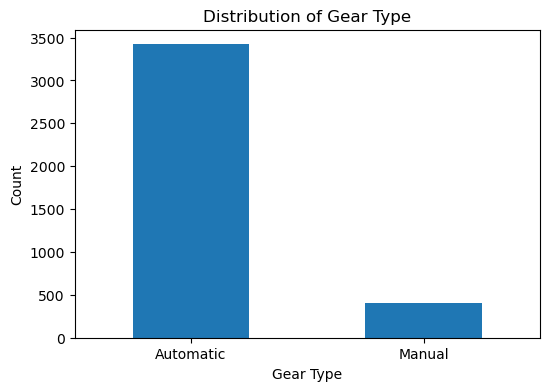

In [50]:
# 3. Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
df_filtered['Gear_Type'].value_counts().plot(kind='bar')
plt.title('Distribution of Gear Type')
plt.ylabel('Count')
plt.xlabel('Gear Type')
plt.xticks(rotation=0)
plt.show()

### 🔍 Feature Analysis: `Gear_Type`

- **Unique Values**: 2 (`Automatic`, `Manual`)  
- **Counts**:  
  - Automatic: 3,420 listings (89.44%)  
  - Manual:    404 listings (10.56%)  
- **Data Quality**:  
  - No typos or inconsistent labels detected  

### ⚠️ Implications

1. **Market Preference**  
   - The Saudi used-car market is overwhelmingly automatic, reflecting buyer demand and driving conditions.  
2. **Model Training**  
   - With only ~10% of cars manual, the model may have less exposure and produce noisier predictions for this subgroup.  
3. **Encoding Strategy**  
   - A simple binary encoding (0/1) is sufficient; no need for one-hot expansion beyond these two categories.  
4. **No Further Cleaning Needed**  
   - Since only valid categories exist and no rare values to group, we can proceed directly to modeling with this feature.  

## Origin

### EDA Steps for `Origin`

1. **Check unique values and distribution**
2. **Check for typos or inconsistent labels**
3. **Visualize the frequency distribution**

### What to Look For

* Are all `Origin` values valid and expected (e.g., Saudi, Gulf, American, Other)?
* Any typos, weird spellings, or casing/whitespace issues?
* Are there any “Other”, “Unknown”, or empty values?
* Is one category overwhelmingly dominant?

In [53]:
# 1. Unique values and counts
print("Unique Origin values:", df_filtered['Origin'].unique())
origin_counts = df_filtered['Origin'].value_counts()
print(origin_counts)

Unique Origin values: ['Saudi' 'Gulf Arabic' 'Other' 'Unknown']
Origin
Saudi          2893
Gulf Arabic     495
Other           420
Unknown          16
Name: count, dtype: int64


### Handling `Unknown` in `Origin`

In the `Origin` column, I found a small subset of listings (16 rows) labeled as `"Unknown"`. This value likely indicates that the seller did not specify the car’s origin when listing it.

### Is `"Unknown"` just missing data?
Yes from a data standpoint, it reflects **missing or undisclosed information**, not a meaningful car specification like "Saudi" or "Other". However, it can still carry business value.

### 🤔 Why not merge `"Unknown"` into `"Other"`?
While both differ from local (`Saudi`) or regional (`Gulf Arabic`) origins, `"Unknown"` and `"Other"` have **different meanings**:

| Origin         | Real-World Meaning                                                                 | Possible Buyer Perception / Price Reality in Data                        |
|----------------|-------------------------------------------------------------------------------------|------------------------------------------|
| `Saudi`        | Car originally sold in Saudi Arabia with GCC specs                                 | Most desirable: local specs, easy resale. Most common: lower median price (market baseline) |
| `Gulf Arabic`  | Imported from another GCC country (e.g. UAE, Kuwait)                               | Trusted, often premium imports; highest prices in data |
| `Other`        | Imported from outside GCC (e.g. US, Europe, Japan); often foreign-spec             | Least desirable: spec mismatch risk      |
| `Unknown`      | Seller did not disclose origin (left blank or chose "Not Sure")                   | Treated with caution: trust/risk penalty |

Merging them would hide this distinction and reduce the model’s ability to learn the subtle impact of **undisclosed origin** vs. **foreign origin**. If `"Unknown"` is merged with `"Other"`, we would unintentionally state that they are made/imported outside of GCC which has a completely different meaning unlike a normal "Other" value in other features.

### Decision: Keep `"Unknown"` as its own category
- It allows the model to **learn the pricing penalty** associated with incomplete listings.
- It makes **interpretation easier**, especially with SHAP or business explanations.
- It **prepares the model for production**, where `"Unknown"` may continue to appear in new listings.

I will retain `"Unknown"` as a separate label throughout the pipeline (training, validation, and inference).

In [54]:
# 2. Check for possible typos/inconsistencies
origin_raw = pd.Series(df_filtered['Origin'].unique())
suspect_origin = origin_raw[origin_raw.str.strip().str.lower().duplicated(keep=False)]
print("Possible near-duplicate or inconsistent Origin labels:")
print(suspect_origin)

Possible near-duplicate or inconsistent Origin labels:
Series([], dtype: object)


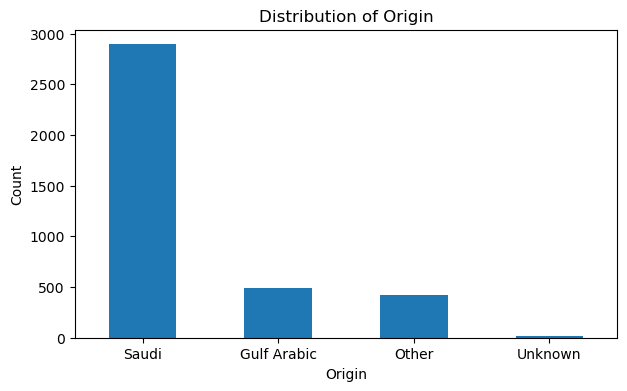

In [56]:
# 3. Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 4))
origin_counts.plot(kind='bar')
plt.title('Distribution of Origin')
plt.ylabel('Count')
plt.xlabel('Origin')
plt.xticks(rotation=0)
plt.show()

In [57]:
origin_percentages = (df_filtered['Origin'].value_counts(normalize=True) * 100).round(2)
print(origin_percentages)

Origin
Saudi          75.65
Gulf Arabic    12.94
Other          10.98
Unknown         0.42
Name: proportion, dtype: float64


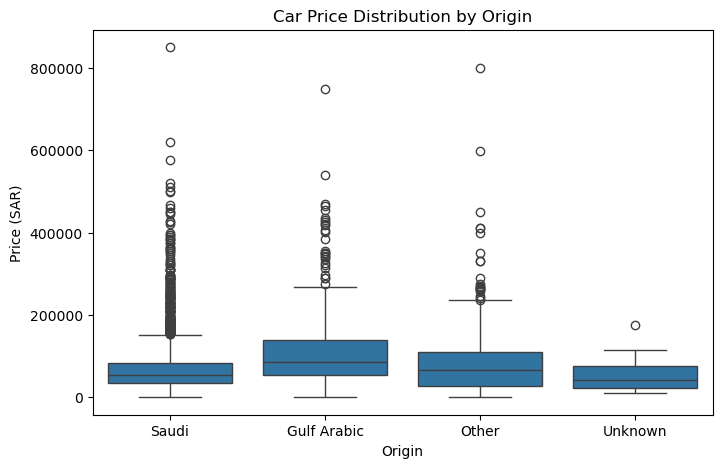

In [61]:
# 4. Visualize price distribution by Origin
plt.figure(figsize=(8, 5))
sns.boxplot(x='Origin', y='Price', data=df_filtered)
plt.title('Car Price Distribution by Origin')
plt.xlabel('Origin')
plt.ylabel('Price (SAR)')
plt.show()

In [66]:
# Print descriptive statistics of Price grouped by Origin
price_stats_by_origin = df_filtered.groupby('Origin')['Price'].describe().sort_values(by='50%', ascending=False)
price_stats_by_origin

,count,mean,std,min,25%,50%,75%,max
Origin,,,,,,,,
Gulf Arabic,495.0,112519.084848,91021.768785,1310.0,54500.0,86000.0,139500.0,748000.0
Other,420.0,84375.226190,84742.237843,500.0,27000.0,65000.0,110250.0,800000.0
Saudi,2893.0,71310.076391,65369.388380,1.0,35000.0,55000.0,82000.0,850000.0
Unknown,16.0,56937.500000,44198.369125,10000.0,23500.0,42250.0,75750.0,175000.0


Based on the filtered fixed-price listings, here’s what I observe:

**Key Takeaways**

1. **Gulf Arabic** cars have the **highest average and median prices**, with a wide spread and several high-end outliers.  
2. **Other** (non-GCC imports) sit in the middle—more expensive than local Saudi stock but less than Gulf Arabic.
3. **Saudi**-origin cars represent the bulk of the market and cluster around lower price points (median 55k SAR).  
4. **Unknown** listings (n=16) have the **lowest median price** but too few samples for strong conclusions.

> **Conclusion:** There is a clear step-up in price from Saudi → Other → Gulf Arabic, reflecting differing supply channels and buyer willingness to pay. "Unknown" listings underperform relative to all specified origins, suggesting possible information-gap discounts.

### 🔍 Feature Analysis: `Origin`

**Unique Values:** 4 → `Saudi`, `Gulf Arabic`, `Other`, `Unknown`

| Origin         | Count | % of Data | Mean Price (SAR) | Median Price (SAR) |
|----------------|-------|-----------|------------------|--------------------|
| Saudi          | 2,893 | 75.7%     | 71,310           | 55,000             |
| Gulf Arabic    | 495   | 12.9%     | 112,519          | 86,000             |
| Other          | 420   | 11.0%     | 84,375           | 65,000             |
| Unknown        | 16    | 0.4%      | 56,938           | 42,250             |

### 💡 Business & Data Insights

| Origin         | Meaning (Business)                                         | Buyer Perception & Price Signal (in Data)         |
|----------------|------------------------------------------------------------|---------------------------------------------------|
| **Saudi**      | Locally purchased, GCC specs                               | Most common; **lowest prices**, baseline market   |
| **Gulf Arabic**| Imported from another GCC country (UAE, Kuwait, etc.)      | Trusted, often premium; **highest prices in data**|
| **Other**      | Imported outside GCC (US, Europe, Asia); foreign spec      | Discounted due to risk/spec mismatch; **mid-range**|
| **Unknown**    | Seller did not specify origin (missing disclosure)         | Least trusted; **lowest prices, trust penalty**   |

### ⚠️ Implications for Modeling

- **Gulf Arabic** cars fetch the highest prices, likely reflecting more premium imports.
- **Saudi** cars are most abundant but cluster at lower prices (market baseline).
- **Other** imports are discounted, as expected for non-local specs.
- **Unknown** receives the lowest prices, confirming a trust or information penalty.
- No typos or inconsistencies found; all values will be retained as-is.

**Bottom Line:**  
`Origin` is a strong price driver with real-world business meaning, clear data-backed segments, and will provide valuable predictive power to the model.


## Options

### 1. **What does the `Options` feature represent?**

* **Business Meaning:**
  In the context of Saudi used car listings, **`Options`** typically refers to the **trim level or option package** of the car.

  * **Standard:** The basic version with the fewest features (manual A/C, cloth seats, simple audio, etc.)
  * **Semi Full:** Mid-level trim, adds some comfort or tech (e.g. better sound system, alloy wheels, parking sensors).
  * **Full:** The top spec, often with all available options (leather seats, sunroof, advanced safety, full infotainment, etc.)

This feature is **crucial** because in the Middle East, buyers place high value on luxury features, even within the same model/year.

### 2. **What to Look For**

* Are there only “Standard”, “Semi Full”, “Full” (or other, unexpected/rare/typo values)?
* Does one level dominate? (Often “Full” is highly desirable and priced higher.)
* Are there inconsistent spellings or cases? (e.g., “semi full” vs. “Semi Full”)
* Is there a price step-up across option levels?

## Price

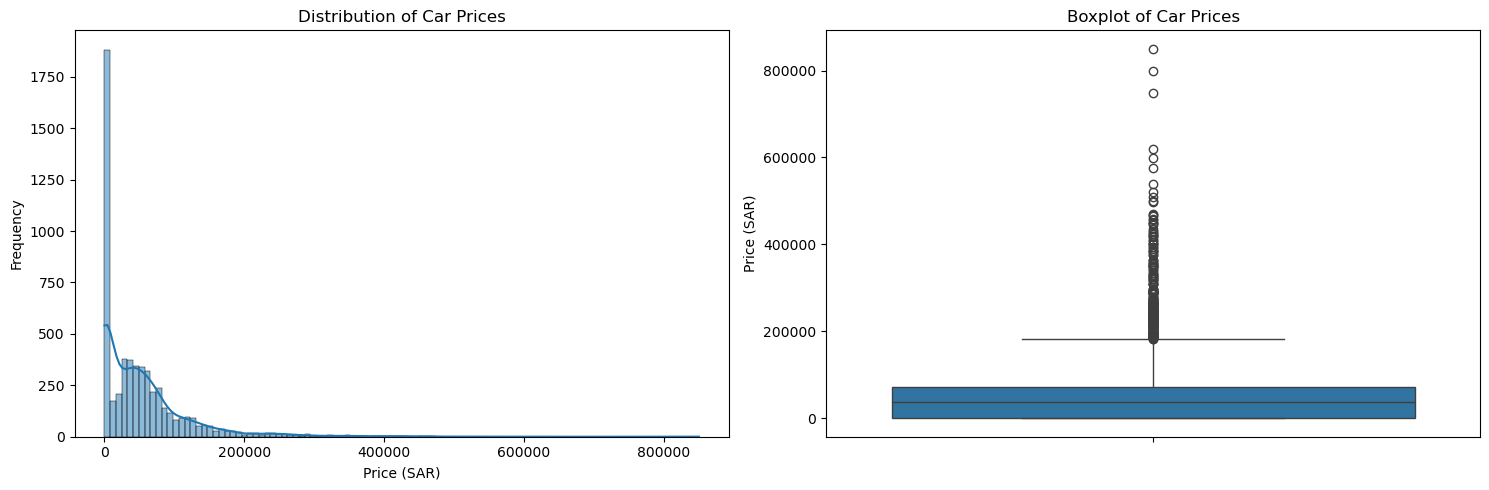

In [35]:
# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot histogram with KDE
sns.histplot(df['Price'], kde=True, ax=ax1)
ax1.set_title('Distribution of Car Prices')
ax1.set_xlabel('Price (SAR)')
ax1.set_ylabel('Frequency')

# Plot boxplot
sns.boxplot(y=df['Price'], ax=ax2)
ax2.set_title('Boxplot of Car Prices')
ax2.set_ylabel('Price (SAR)')

plt.tight_layout()
plt.show()

In [36]:
# Calculate IQR for Price
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as values below (Q1 - 1.5*IQR) or above (Q3 + 1.5*IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]

# Count outliers and calculate percentage
outlier_count = len(outliers)
outlier_percentage = (outlier_count / len(df)) * 100

print(f"Number of outliers: {outlier_count}")
print(f"Percentage of outliers: {outlier_percentage:.2f}%")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")

# Display statistics of outliers
print("\nStatistics of outliers:")
print(outliers['Price'].describe())

Number of outliers: 261
Percentage of outliers: 4.64%
Lower bound: -109500.00
Upper bound: 182500.00

Statistics of outliers:
count       261.000000
mean     284848.275862
std      102655.374765
min      183000.000000
25%      220000.000000
50%      251500.000000
75%      325000.000000
max      850000.000000
Name: Price, dtype: float64


### Test after removing Negotiable prices

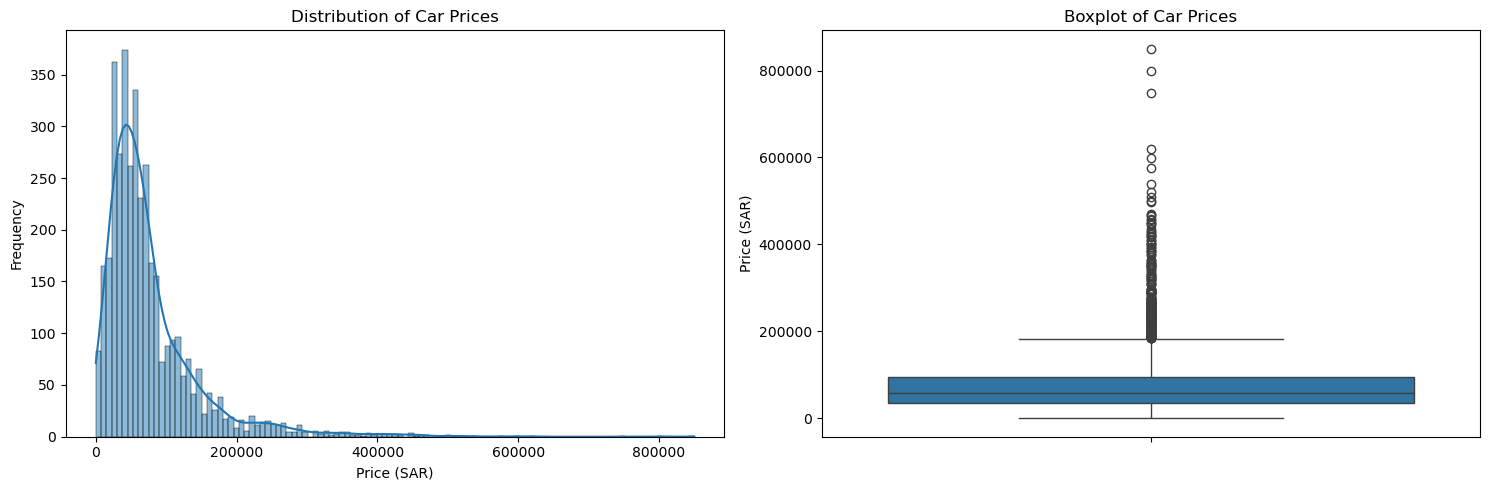

In [37]:
# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot histogram with KDE
sns.histplot(df_filtered['Price'], kde=True, ax=ax1)
ax1.set_title('Distribution of Car Prices')
ax1.set_xlabel('Price (SAR)')
ax1.set_ylabel('Frequency')

# Plot boxplot
sns.boxplot(y=df_filtered['Price'], ax=ax2)
ax2.set_title('Boxplot of Car Prices')
ax2.set_ylabel('Price (SAR)')

plt.tight_layout()
plt.show()

In [38]:
# Calculate IQR for Price
Q1 = df_filtered['Price'].quantile(0.25)
Q3 = df_filtered['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as values below (Q1 - 1.5*IQR) or above (Q3 + 1.5*IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_filtered[(df_filtered['Price'] < lower_bound) | (df_filtered['Price'] > upper_bound)]

# Count outliers and calculate percentage
outlier_count = len(outliers)
outlier_percentage = (outlier_count / len(df_filtered)) * 100

print(f"Number of outliers: {outlier_count}")
print(f"Percentage of outliers: {outlier_percentage:.2f}%")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")

# Display statistics of outliers
print("\nStatistics of outliers:")
print(outliers['Price'].describe())

Number of outliers: 259
Percentage of outliers: 6.77%
Lower bound: -53875.00
Upper bound: 183125.00

Statistics of outliers:
count       259.000000
mean     285634.749035
std      102658.582321
min      185000.000000
25%      220000.000000
50%      252000.000000
75%      325000.000000
max      850000.000000
Name: Price, dtype: float64
